# Analisi sui minuti di recupero Serie A 2022-23

In [1]:
import requests
from tqdm import tqdm
from requests.auth import HTTPBasicAuth
from pprint import pprint
import pandas as pd
import numpy as np

import seaborn as sns
from statistics import median
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.colors as mcolors

from PIL import Image
import urllib
import matplotlib.font_manager as fm
from matplotlib import cm
from highlight_text import fig_text

import plotly.graph_objects as go
import plotly.express as px

import math
import os

# Add pretty fonts
font_path = r"../assets/fonts" #Set the path to where the fonts are located

for x in os.listdir(font_path):
    for y in os.listdir(f"{font_path}/{x}"):
        if y.split(".")[-1] == "ttf":
            fm.fontManager.addfont(f"{font_path}/{x}/{y}")
            try:
                fm.FontProperties(weight=y.split("-")[-1].split(".")[0].lower(), fname=y)
            except Exception as e:
                print(f"Font {y} could not be added.")
                continue


teams = ['Fiorentina', 'Milan', 'Atalanta', 'Bologna', 'Cremonese', 'Empoli', 'Hellas Verona', 'Internazionale', 'Juventus', 'Lazio', 'Lecce', 'Monza', 'Roma',
        'Napoli', 'Salernitana', 'Sampdoria', 'Sassuolo', 'Spezia', 'Torino', 'Udinese', 'Genoa', 'Cagliari', 'Venezia', 'Benevento', 'Crotone', 'Parma', 'Brescia', 'Spal']

footId = [8535, 8564, 8524, 9857, 7801, 8534, 9876, 8636, 9885, 8543, 9888, 6504, 8686,
          9875, 6480, 9882, 7943, 9881, 9804, 8600, 10233, 8529, 7881, 6266, 9884, 10167, 9858, 8547]

footTeams = pd.DataFrame({'Team': teams,
                   'footId': footId})

gradient = [
    '#02315E',
    '#00457E',
    '#2F70AF',
    '#B9848C',
    '#806491',
]
soc_cm = mcolors.LinearSegmentedColormap.from_list('SOC', gradient, N=50)
cm.register_cmap(name='SOC', cmap=soc_cm)

# --- Reading the data
df = pd.read_excel('../data/SerieA_22_23_minuti_recupero.xlsx')


Font DMSans-BoldItalic.ttf could not be added.
Font DMSans-Italic.ttf could not be added.
Font DMSans-MediumItalic.ttf could not be added.
Font Karla-BoldItalic.ttf could not be added.
Font Karla-ExtraBold.ttf could not be added.
Font Karla-ExtraBoldItalic.ttf could not be added.
Font Karla-ExtraLight.ttf could not be added.
Font Karla-ExtraLightItalic.ttf could not be added.
Font Karla-Italic.ttf could not be added.
Font Karla-MediumItalic.ttf could not be added.
Font Karla-SemiBoldItalic.ttf could not be added.


Data Preprocessing

In [2]:
# fill NaN with 0
df = df.fillna(0)
# cast to int all the real columns
df = df.astype({'goalRecH1':'int32','goalRecH2':'int32','puntiRec':'int32'})
# evaluate total game time
df.loc[:,'totalMin'] = df['firstHmin']+df['secondHmin']
df.loc[:,'totalGoalRec'] = df['goalRecH1']+df['goalRecH2']
df['Comp'] = 'SerieA'
df_serieA = df
df1 = df.groupby(by='Team').sum()[['firstHmin', 'secondHmin', 'totalMin', 'totalGoalRec','puntiRec']]
df2 = df1.copy()
df2 = df2.sort_values(by='totalMin', ascending=True).reset_index()
df3 = pd.merge(df2, footTeams, how = "left")
df3.loc[:,'minRec'] = df3.loc[:,'totalMin'] - 1350
df3['goalRec_90min'] = round((df3['totalGoalRec']/df3['minRec'])*90,2)


Visualizzazioni

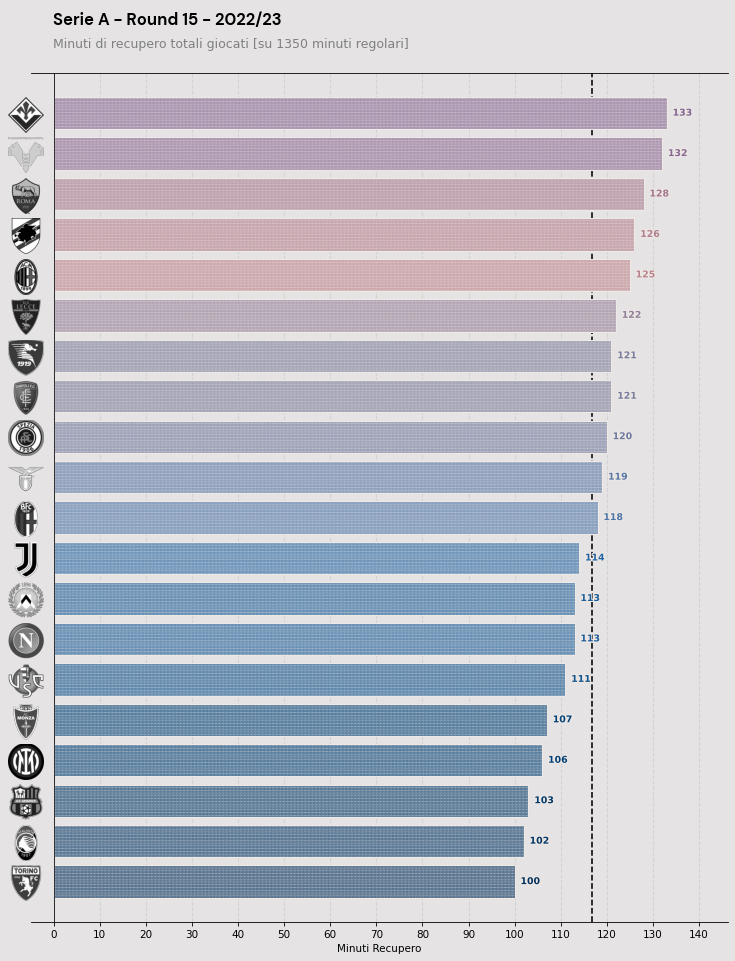

In [3]:
data = df3
def add_logo_on_ax(ax, team_id, bw = True):
    '''
    This function adds the logo of a football team on a specific
    axes based on the Fotmob team ID.
    Args:
        - ax (object): the matplotlib axes object.
        - team_id (int): the Fotmob team ID.
        - bw (bool): whether to add the logo as black & white or with color.
    '''
    fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
    club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}{team_id:.0f}.png')).convert('LA')
    if bw:
        club_icon = club_icon.convert('LA')
    ax.imshow(club_icon)
    ax.axis("off")
    return ax

fig = plt.figure(figsize=(12,15), dpi=75, facecolor = "#E5E3E4")
ax = plt.subplot(facecolor = "#E5E3E4")
# -- Axes settings --------------------------------
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(ls='--', lw=1, color='lightgrey', axis='x')
ax.yaxis.set_ticks([])
# -- Hatches --------------------------------------
plt.rcParams['hatch.linewidth'] = 1
# -- Axes limits and tick positions ---------------
# Ensure symmetrical limits on the x-axis
max_ = data['minRec'].max()
# Add 10% margin of the limit to the x-axis
max_ = max_*(1.1)
ax.set_xlim(-5, max_)
ax.set_ylim(-1, data.shape[0])
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.set_xlabel('Minuti Recupero', size=10)
# -- Bar Chart -------------------------------------
# Declare CMAP & Normalization
norm = mcolors.Normalize(vmin=data['minRec'].min(),vmax=data['minRec'].max())
cmap = plt.get_cmap('SOC')

ax.barh(
    data.index, data['minRec'],
    hatch='........', ec='#efe9e6',
    color = cmap(norm(data['minRec'])),
    zorder=3
)
ax.plot(
    [0,0],
    [ax.get_ylim()[0], ax.get_ylim()[1]],
    color='black',
    lw=.75,
    zorder=3
)

min_rec_avg = data['minRec'].mean()
ax.axvline(x=min_rec_avg, color='black', linestyle='--', label='Tempo regolamentare')

# -- Annotations -----------------------------------
# -- Transforms for the placement of the logo ax ---
DC_to_FC = ax.transData.transform
FC_to_NFC = fig.transFigure.inverted().transform
DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))
offset_logo = .65
for index, x in enumerate(data['minRec']):
    text_ = ax.annotate(
        xy=(x, index),
        xytext=(15,0),
        text=f'{x:.0f}',
        color= cmap(norm(x)),
        size=9,
        weight='bold',
        ha='center',
        va='center',
        textcoords='offset points'
    )
    text_.set_path_effects([
        path_effects.Stroke(
            linewidth=2, 
            foreground='#efe9e6'
        ), 
        path_effects.Normal()
    ])

    # -- Add the logo
    team_id = data['footId'].iloc[index]
    ax_coords = DC_to_NFC([-10, index - 0.6])
    logo_ax = fig.add_axes([ax_coords[0], ax_coords[1], 0.04, 0.04], anchor = "C")
    add_logo_on_ax(logo_ax, team_id, True)



fig_text(
    x = 0.15, y = .92, 
    s = 'Serie A - Round 15 - 2022/23',
    va = 'bottom', ha = 'left',
    fontsize = 16, color = 'black', font = 'DM Sans', weight = 'bold'
)

fig_text(
    x = 0.15, y = 0.9, 
    s = 'Minuti di recupero totali giocati [su 1350 minuti regolari]',
    va = 'bottom', ha = 'left',
    fontsize = 12, color = 'gray'
)

plt.savefig(
	"../figures/1_SerieA_15_22_23_minuti_recupero_totali.png",
	dpi = 600,
	facecolor = "#EFE9E6",
	bbox_inches="tight",
    edgecolor="none",
	transparent = False
)

plt.show()

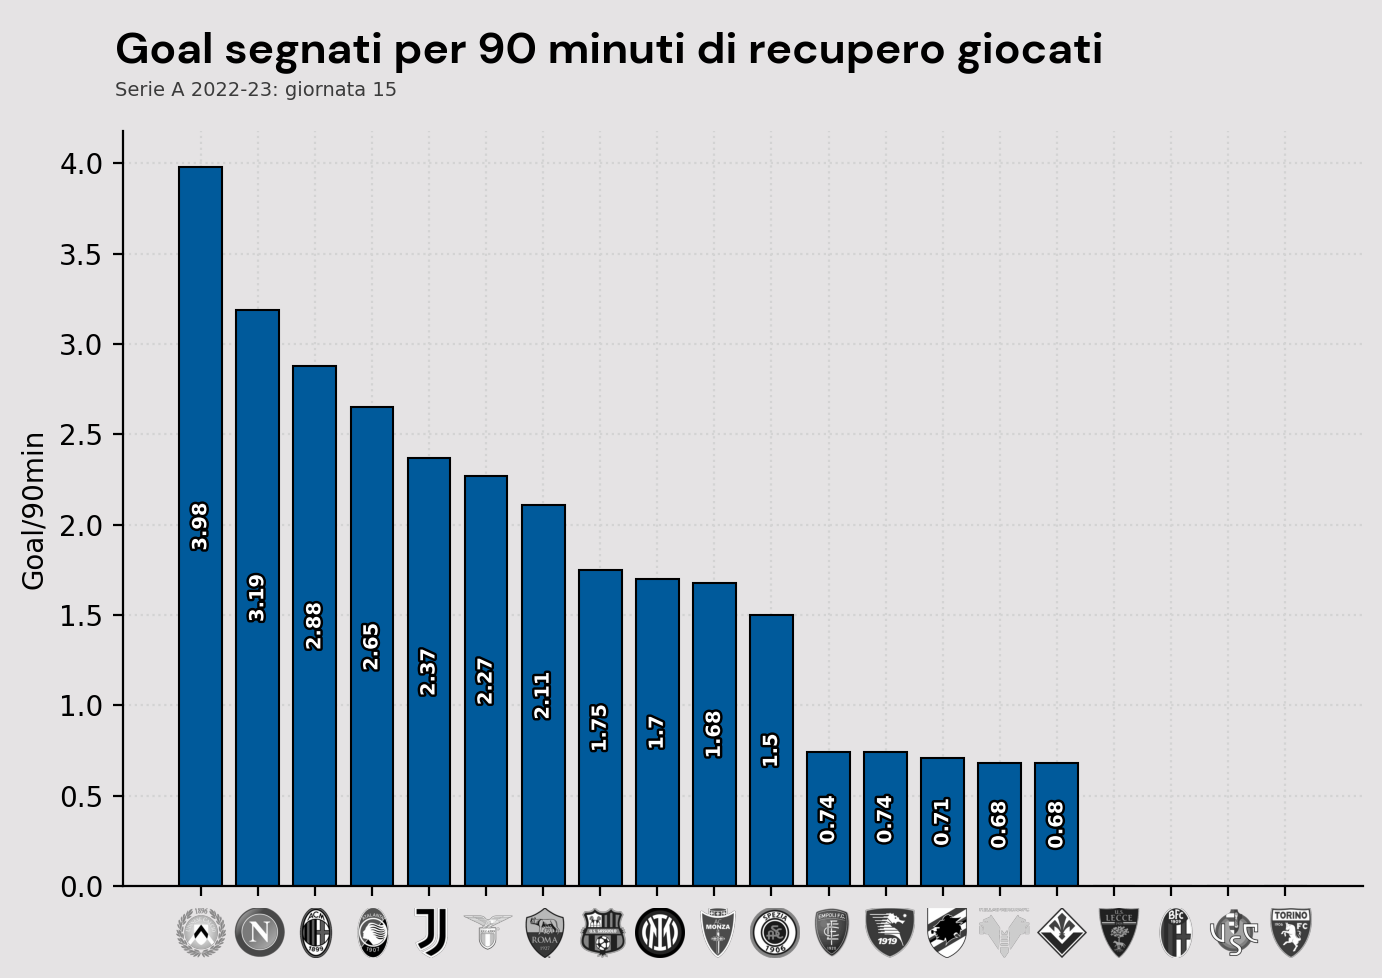

In [4]:
data = df3.sort_values(by='goalRec_90min', ascending=False).reset_index(drop=True)
height_n = (
    data["goalRec_90min"]
    .reset_index(drop = True)
)

# We'll annotate the x-axis differently.
X = np.arange(len(height_n))
sort_order = data["Team"].to_list()

width = 0.5
fig = plt.figure(figsize=(8, 5), dpi = 200, facecolor = "#E5E3E4")
ax = plt.subplot(111, facecolor = "#E5E3E4")

# Add spines
ax.spines["top"].set(visible = False)
ax.spines["right"].set(visible = False)

# Add grid and axis labels
ax.grid(True, color = "lightgrey", ls = ":")
ax.set_ylabel("Goal/90min", fontsize=10)
width = 0.75
ax.bar(
    X, 
    height_n, 
    ec = "black", 
    lw = .75, 
    color = "#005a9b", 
    zorder = 2, 
    width = width,
    label = "Goal ogni 90 minuti di recupero"
)

# Annotate the bar chart
aux_counter = 0
for y_n in height_n:
    # annotate percentage of fouls in the center of the bar
    if (y_n!=0):
        n_text = ax.annotate(
            xy = (aux_counter, y_n/2),
            text = f"{y_n}", # F-strings are cool :)
            size = 7,
            ha = "center",
            va = "center",
            weight = "bold",
            color = "white",
            rotation = 90
        )


    n_text.set_path_effects(
        [path_effects.Stroke(linewidth=1.75, foreground="black"), path_effects.Normal()]
    )

    aux_counter += 1


xticks_ = ax.xaxis.set_ticks(
    ticks = X,
    labels = [],
    rotation = 90
)


fotmob_url = "https://images.fotmob.com/image_resources/logo/teamlogo/"
for index, team_id in enumerate(data["footId"]):
    ax_coords = DC_to_NFC([7*index + 2*width, -3])
    logo_ax = fig.add_axes([ax_coords[0], ax_coords[1], 0.05, 0.05], anchor = "W")
    club_icon = Image.open(urllib.request.urlopen(f"{fotmob_url}{team_id:.0f}.png")).convert("LA")
    logo_ax.imshow(club_icon)
    logo_ax.axis("off")


fig_text(
    x = 0.12, y = .98,
    s = "Goal segnati per 90 minuti di recupero giocati",
    fontsize = 16, color = 'black', font = 'DM Sans', weight = 'bold'
)
title = "Serie A 2022-23: giornata 15"
fig_text(
    x = 0.12, y = .93,
    s = title,
    color = "#3b3b3b",
    fontsize = 7
)

filename = "../figures/2_Goal_nei_recuperi_SerieA_22_23_giornata15.png"
plt.savefig(
	  filename,
	  dpi = 600,
	  facecolor = "#928287",
	  bbox_inches="tight",
      edgecolor="none",
	  transparent = False
  )
plt.show()

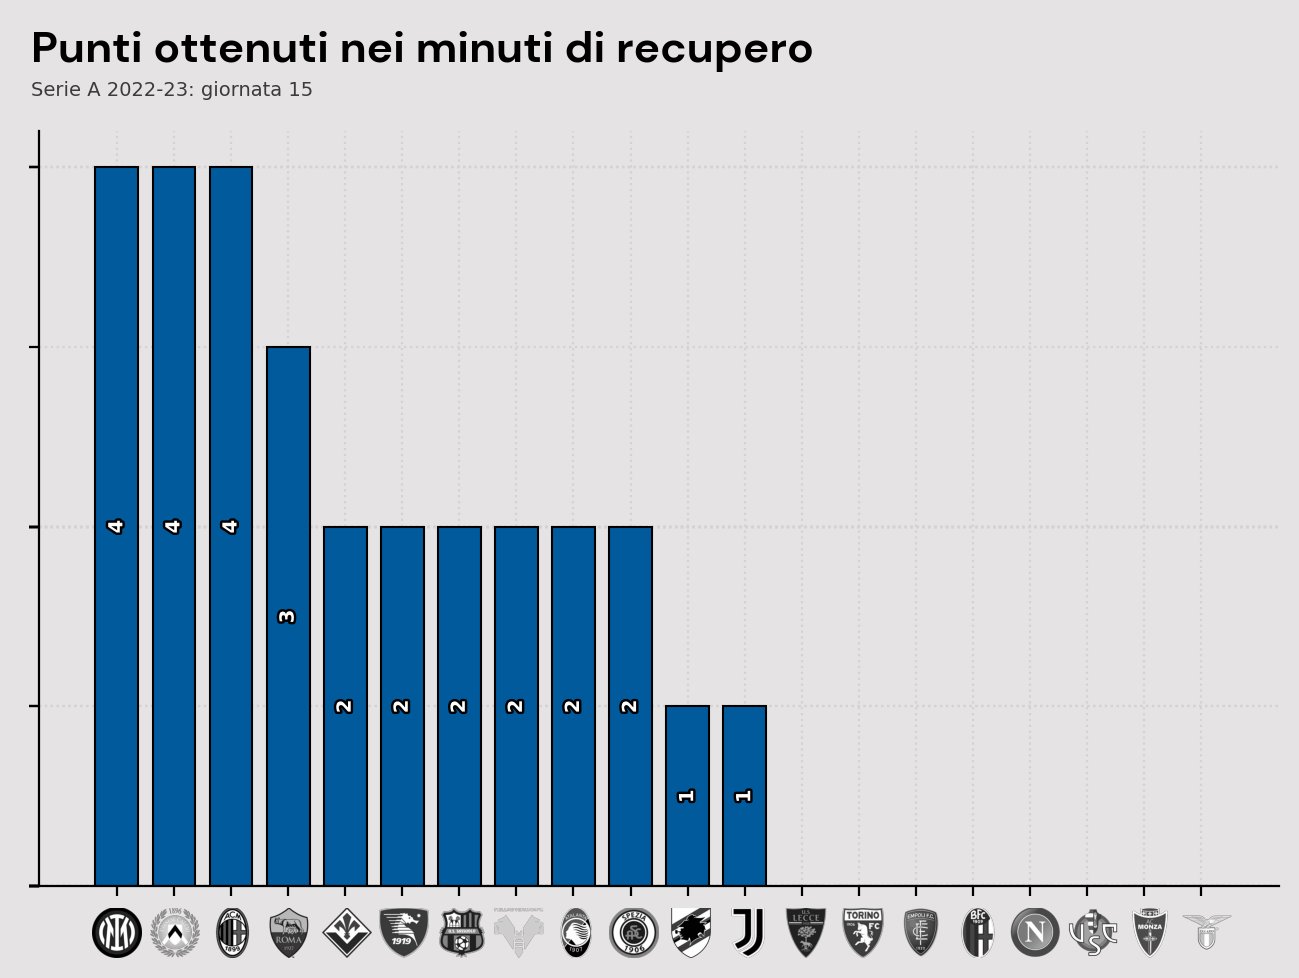

In [5]:
data = df3.sort_values(by='puntiRec', ascending=False).reset_index(drop=True)
height_n = (
    data["puntiRec"]
    .reset_index(drop = True)
)


# We'll annotate the x-axis differently.
X = np.arange(len(height_n))
sort_order = data["Team"].to_list()

width = 0.5
fig = plt.figure(figsize=(8, 5), dpi = 200, facecolor = "#E5E3E4")
ax = plt.subplot(111, facecolor = "#E5E3E4")

# Add spines
ax.spines["top"].set(visible = False)
ax.spines["right"].set(visible = False)

# Add grid and axis labels
ax.grid(True, color = "lightgrey", ls = ":")
#ax.set_ylabel("#", fontsize=10)
width = 0.75
ax.bar(
    X, 
    height_n, 
    ec = "black", 
    lw = .75, 
    color = "#005a9b", 
    zorder = 2, 
    width = width,
    label = "Punti ottenuti nei recuperi"
)

# Annotate the bar chart
aux_counter = 0
for y_n in height_n:
    # annotate percentage of fouls in the center of the bar
    if (y_n!=0):
        n_text = ax.annotate(
            xy = (aux_counter, y_n/2),
            text = f"{y_n}", # F-strings are cool :)
            size = 7,
            ha = "center",
            va = "center",
            weight = "bold",
            color = "white",
            rotation = 90
        )


    n_text.set_path_effects(
        [path_effects.Stroke(linewidth=1.75, foreground="black"), path_effects.Normal()]
    )

    aux_counter += 1


xticks_ = ax.xaxis.set_ticks(
    ticks = X,
    labels = [],
    rotation = 90
)
xticks_ = ax.yaxis.set_ticks(
    ticks = height_n,
    labels = []
)

fotmob_url = "https://images.fotmob.com/image_resources/logo/teamlogo/"
for index, team_id in enumerate(data["footId"]):
    ax_coords = DC_to_NFC([7*index + 2*width, -3])
    logo_ax = fig.add_axes([ax_coords[0], ax_coords[1], 0.05, 0.05], anchor = "W")
    club_icon = Image.open(urllib.request.urlopen(f"{fotmob_url}{team_id:.0f}.png")).convert("LA")
    logo_ax.imshow(club_icon)
    logo_ax.axis("off")


fig_text(
    x = 0.12, y = .98,
    s = "Punti ottenuti nei minuti di recupero",
    fontsize = 16, color = 'black', font = 'DM Sans', weight = 'bold'
)
title = "Serie A 2022-23: giornata 15"
fig_text(
    x = 0.12, y = .93,
    s = title,
    color = "#3b3b3b",
    size = 7
)

filename = "../figures/3_Punti_nei_recuperi_SerieA_22_23_giornata15.png"
plt.savefig(
	  filename,
	  dpi = 600,
	  facecolor = "#928287",
	  bbox_inches="tight",
      edgecolor="none",
	  transparent = False
  )
plt.show()

Caricamento numeri Qatar 2022 e grafico distribuzione

In [6]:
# --- Reading the data
df_qatar = pd.read_excel('../data/Qatar2022_recuperi.xlsx')
df_qatar['Comp'] = "Qatar-2022"
df_qatar.rename(columns={'Totale':'totalMin'}, inplace=True)

df_total = pd.concat([df_serieA[['Comp', 'totalMin']], df_qatar[['Comp', 'totalMin']]])

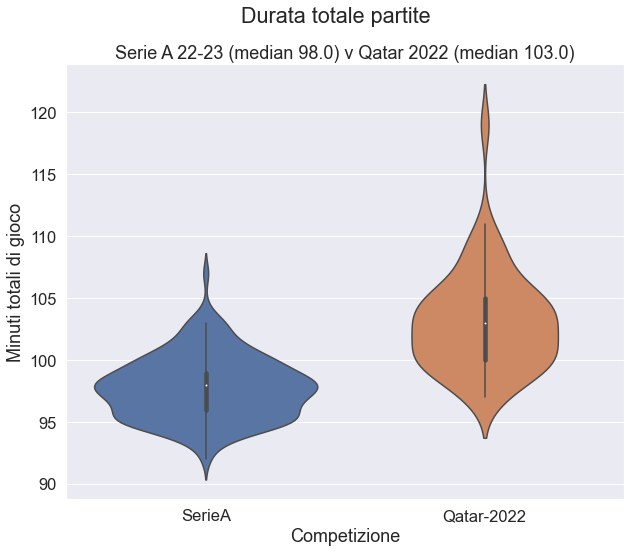

In [10]:
# 
S_A = df_total.query('Comp == "SerieA"')['totalMin']
WC = df_total.query('Comp == "Qatar-2022"')['totalMin']

fig = plt.gcf()

# Change seaborn plot size
fig.set_size_inches(10, 8)

# Increase font size
sns.set(font_scale=1.5)

# Create the violin plot
sns.violinplot(y='totalMin', x='Comp',
              data=df_total)

# Change Axis labels:
medSerieA = median(S_A)
medQatar2022 = median(WC)
title = 'Serie A 22-23 (median '+ str(medSerieA) + ') v Qatar 2022 (median '+str(medQatar2022)+')'
plt.xlabel('Competizione')
plt.ylabel('Minuti totali di gioco')
plt.suptitle('Durata totale partite')
plt.title(title)

filename = "../figures/4_Distribuzione_minuti_recupero.png"
plt.savefig(
	  filename,
	  dpi = 600,
	  facecolor = "#928287",
	  bbox_inches="tight",
      edgecolor="none",
	  transparent = False
  )
plt.show()